In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib.backends.backend_pdf import PdfPages

## Data Preprocessing

In [2]:
def load_data_from_csv(CSV_PATH):
    return pd.read_csv(CSV_PATH,delimiter = ';',
                       names = ["module_sub_routine","id","hardware_Counter","time","event"])

def drop_columns(dataFrame,list_col):
    return dataFrame.drop(list_col,axis=1)

# Modifying the data

arr = ['module_sub_routine','id','time']
scalerPath = '../../data/WACCM_imp_sol_scaler.slope.labelled.csv'
scalarDF = load_data_from_csv(scalerPath)
scalarDF = drop_columns(scalarDF,arr)
    
vectorPath = '../../data/WACCM_imp_sol_vector.slope.labelled.csv'
vectorDF = load_data_from_csv(vectorPath)
vectorDF = drop_columns(vectorDF,arr)
    
psradPath = '../../data/mg2/PSrad.exe.codeblocks.fused.any.any.any.slope.labelled .csv'
psradDF = load_data_from_csv(psradPath)
psradDF = drop_columns(psradDF,arr)
    
wetdepaPath = '../../data/wetdepa_driver_v0.labelled.csv'
wetdepaDF = load_data_from_csv(wetdepaPath)
wetdepaDF = drop_columns(wetdepaDF,arr)
    
clubbPath = '../../data/clubb.labelled.csv'
clubbDF = load_data_from_csv(clubbPath)
clubbDF = drop_columns(clubbDF,arr)

In [3]:
def get_CounterNames(dataFrame):
    counter_name = dataFrame['hardware_Counter']
    return counter_name.unique()

def remove_ABS_Counter(counterNames):
    counterName = []
    for str in counterNames:
        if "_per_ins" in str:
            counterName.append(str)
        elif "LABEL" == str:
            counterName.append(str)
    return counterName

In [4]:
counter_name = get_CounterNames(vectorDF)
counterNameList = remove_ABS_Counter(counter_name) 
counterNameList.remove("PAPI_VEC_DP_per_ins")

In [5]:
def rearrange(dataFrame,counterNameList):
    df_per_ins = pd.DataFrame(columns = counterNameList)
    for tempStr in counterNameList:
        temp_df = dataFrame[dataFrame['hardware_Counter'] == tempStr]
        df_per_ins[tempStr] = temp_df['event'].values
    df_per_ins = df_per_ins[~df_per_ins.isin([np.nan,np.inf,-np.inf]).any(1)]
    return df_per_ins

In [6]:
scalarDF = rearrange(scalarDF,counterNameList)
vectorDF = rearrange(vectorDF,counterNameList)
psradDF = rearrange(psradDF,counterNameList)
wetdepaDF = rearrange(wetdepaDF,counterNameList)
clubbDF = rearrange(clubbDF,counterNameList)    

In [7]:
def append_DataFrames(dataFrameA,dataFrameB):
    return dataFrameA.append(dataFrameB)

In [8]:
resultDF = append_DataFrames(scalarDF,vectorDF)
resultDF = append_DataFrames(resultDF, psradDF)
resultDF = append_DataFrames(resultDF,wetdepaDF)

## Create Test Case

In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(resultDF,test_size = 0.2, random_state=42)
print(len(train_set),"Train +",len(test_set),"test")

(2795, 'Train +', 699, 'test')


## Prepare Data for ML

In [10]:
train_Features = train_set.drop("LABEL",axis=1)
train_Labels = train_set["LABEL"].copy()

In [11]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(train_Features,train_Labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [12]:
from sklearn.metrics import mean_squared_error

label_predictions = forest_reg.predict(train_Features)
forest_mse = mean_squared_error(train_Labels, label_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.036285490922964965

In [13]:
def display_scores(scores):
    print("Scores :", scores)
    print("Mean :",scores.mean())
    print("Standard Deviation :",scores.std())

In [16]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, train_Features, train_Labels,
                                scoring= "neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

('Scores :', array([0.04633239, 0.17023608, 0.10964245, 0.03783024, 0.04056841]))
('Mean :', 0.08092191415585141)
('Standard Deviation :', 0.05192999432165836)


### GridSearch CV

In [17]:
import numpy as np

from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

param_grid = [
                    {'n_estimators' : [10,30,100], 'max_features':[2,4,6,8,10,20,30,40]},
                    {'bootstrap':[False],'n_estimators':[3,10,20,50,70,100],'max_features':[2,4,6,8,10,20,30,40]},
                ]

forest_reg = RandomForestRegressor()


grid_search = GridSearchCV(forest_reg,param_grid,cv =10, scoring = 'neg_mean_squared_error')

grid_search.fit(train_Features,train_Labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 30, 100], 'max_features': [2, 4, 6, 8, 10, 20, 30, 40]}, {'n_estimators': [3, 10, 20, 50, 70, 100], 'max_features': [2, 4, 6, 8, 10, 20, 30, 40], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [18]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 2, 'n_estimators': 20}

In [19]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [20]:
cvres = grid_search.cv_results_
for mean_score , params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score),params)

(0.06408848980853876, {'max_features': 2, 'n_estimators': 10})
(0.057772884828673314, {'max_features': 2, 'n_estimators': 30})
(0.059743159337672706, {'max_features': 2, 'n_estimators': 100})
(0.07835518415344916, {'max_features': 4, 'n_estimators': 10})
(0.0689299766543863, {'max_features': 4, 'n_estimators': 30})
(0.06467975326951524, {'max_features': 4, 'n_estimators': 100})
(0.06541459903906666, {'max_features': 6, 'n_estimators': 10})
(0.06646361444669574, {'max_features': 6, 'n_estimators': 30})
(0.06385022725544874, {'max_features': 6, 'n_estimators': 100})
(0.055983641873532775, {'max_features': 8, 'n_estimators': 10})
(0.07065021579197754, {'max_features': 8, 'n_estimators': 30})
(0.0660893307744771, {'max_features': 8, 'n_estimators': 100})
(0.07157817198580901, {'max_features': 10, 'n_estimators': 10})
(0.06586277392478834, {'max_features': 10, 'n_estimators': 30})
(0.06992866285785576, {'max_features': 10, 'n_estimators': 100})
(0.07461289485546038, {'max_features': 20, 'n_

In [21]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.03500909, 0.09015242, 0.02861988, 0.00325752, 0.00839334,
       0.05502795, 0.03591245, 0.03344334, 0.00114876, 0.00040032,
       0.01797174, 0.00137081, 0.00635111, 0.04927094, 0.04549601,
       0.05027513, 0.01026072, 0.05602729, 0.01820934, 0.00089901,
       0.00191397, 0.01681044, 0.06883927, 0.02157763, 0.04275507,
       0.01210326, 0.00018925, 0.03075936, 0.01257372, 0.05016373,
       0.02467627, 0.00015334, 0.00115755, 0.02990309, 0.01999882,
       0.0024464 , 0.01576202, 0.00101942, 0.05228545, 0.03710586,
       0.0003279 , 0.00998097])

In [22]:
sorted(zip(feature_importances, counterNameList),reverse =True) # Importance Score

[(0.09015242450980018, 'PAPI_BR_INS_per_ins'),
 (0.06883927150206381, 'PAPI_L2_TCA_per_ins'),
 (0.05602728830563632, 'PAPI_L2_ICA_per_ins'),
 (0.05502795230811156, 'PAPI_BR_TKN_per_ins'),
 (0.052285454118938215, 'PAPI_TLB_DM_per_ins'),
 (0.05027513199176944, 'PAPI_L2_DCR_per_ins'),
 (0.05016373331747187, 'PAPI_L3_ICA_per_ins'),
 (0.04927094470710776, 'PAPI_L2_DCA_per_ins'),
 (0.04549601079564879, 'PAPI_L2_DCM_per_ins'),
 (0.04275507412008929, 'PAPI_L2_TCR_per_ins'),
 (0.037105861804717755, 'PAPI_TLB_IM_per_ins'),
 (0.03591245463870073, 'PAPI_BR_UCN_per_ins'),
 (0.03500908899056993, 'PAPI_BR_CN_per_ins'),
 (0.03344334075913261, 'PAPI_DP_OPS_per_ins'),
 (0.03075935660713605, 'PAPI_L3_DCR_per_ins'),
 (0.029903093374064393, 'PAPI_L3_TCW_per_ins'),
 (0.02861988491686595, 'PAPI_BR_MSP_per_ins'),
 (0.024676274341759178, 'PAPI_L3_ICR_per_ins'),
 (0.0215776319150433, 'PAPI_L2_TCM_per_ins'),
 (0.0199988201496201, 'PAPI_LD_INS_per_ins'),
 (0.018209341586636625, 'PAPI_L2_ICH_per_ins'),
 (0.0179717

In [23]:
final_model = grid_search.best_estimator_

test_Features = test_set.drop("LABEL",axis=1)
test_Labels = test_set["LABEL"].copy()


final_prediction_grid = final_model.predict(test_Features)

final_mse = mean_squared_error(test_Labels, final_prediction_grid)
final_rmse = np.sqrt(final_mse)

final_rmse

0.0476935856440673

In [24]:
clubb_Features = clubbDF.drop("LABEL",axis=1)
clubb_Labels = clubbDF["LABEL"].copy()

clubb_prediction = final_model.predict(clubb_Features)

final_mse = mean_squared_error(clubb_Labels, clubb_prediction)
final_rmse = np.sqrt(final_mse)

final_rmse

0.7763089304880859

In [25]:
q1_Actual = 0
q1_predict = 0
q2_predict = 0
q3_Actual = 0
q3_predict = 0
q4_predict = 0

correctPred = []
correctLabel = []
badPred = []
badLabel = []
        
timslots = []
tempVal = []
for i in range(len(clubb_prediction)):
    threshold = abs(clubb_Labels[i] * (float(80)/float(100)))
    if clubb_Labels[i] < 0 :
        q3_Actual = q3_Actual +1
        if clubb_prediction[i] > 0:
            q2_predict = q2_predict +1
            badPred.append(clubb_prediction[i])
            badLabel.append(clubb_Labels[i])
        else:
            q3_predict = q3_predict + 1
            correctPred.append(clubb_prediction[i])
            correctLabel.append(clubb_Labels[i])
            if abs(clubb_prediction[i] - clubb_Labels[i]) < threshold:
                timslots.append(i)
                tempVal.append(clubb_prediction[i])
    else :
        q1_Actual = q1_Actual +1
        if clubb_prediction[i] > 0:
            q1_predict = q1_predict +1
            correctPred.append(clubb_prediction[i])
            correctLabel.append(clubb_Labels[i])
        else: 
            q4_predict = q4_predict + 1
            badPred.append(clubb_prediction[i])
            badLabel.append(clubb_Labels[i])
        
correctPrediction = q3_predict + q1_predict
wrongPrediction = q2_predict + q4_predict
total = q3_Actual + q1_Actual

print timslots        
print q3_predict
print q1_predict
print q2_predict
        
goodPercent = round(float((float(correctPrediction)/float(total))*100),2)
badPercent = round(float((float(wrongPrediction)/float(total))*100),2)

clubb_Labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 109, 110, 114, 115, 116, 117, 118, 119, 131, 132, 133, 134, 135, 136, 137, 138, 139, 168, 169, 170, 171, 172, 178, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 241, 246, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 

0     -1.0
1     -1.0
2     -1.0
3     -1.0
4     -1.0
5     -1.0
6     -1.0
7     -1.0
8     -1.0
9     -1.0
10    -1.0
11    -1.0
12    -1.0
13    -1.0
14    -1.0
15    -1.0
16    -1.0
17    -1.0
18    -1.0
19    -1.0
20    -1.0
21    -1.0
22    -1.0
23    -1.0
24    -1.0
25    -1.0
26    -1.0
27    -1.0
28    -1.0
29    -1.0
      ... 
870   -1.0
871   -1.0
872   -1.0
873   -1.0
874   -1.0
875   -1.0
876   -1.0
877   -1.0
878   -1.0
879   -1.0
880   -1.0
881   -1.0
882   -1.0
883   -1.0
884   -1.0
885   -1.0
886   -1.0
887   -1.0
888   -1.0
889   -1.0
890   -1.0
891   -1.0
892   -1.0
893   -1.0
894   -1.0
895   -1.0
896   -1.0
897   -1.0
898   -1.0
899   -1.0
Name: LABEL, Length: 900, dtype: float64

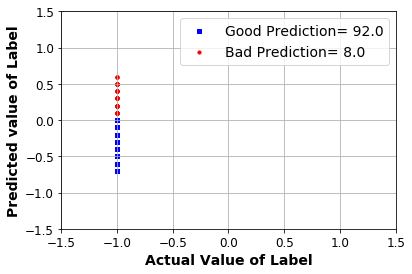

In [26]:
fig, ax = plt.subplots()
        
ax.scatter(correctLabel,correctPred,s=10,c='b',marker='s',label = 'Good Prediction= {}'.format(goodPercent))
        
ax.scatter(badLabel,badPred,s=10,c='r',marker = 'o',label = 'Bad Prediction= {}'.format(badPercent))
        
        
ax.legend(loc = 'upper right', prop={'size': 14})
ax.set_xlabel('Actual Value',fontsize=14 , fontweight = 'bold')
ax.set_ylabel('Prediction Value',fontsize=14, fontweight = 'bold')
    
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
    
ax.set_xlabel('Actual Value of Label')
ax.set_ylabel('Predicted value of Label')
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
ax.grid(True)
        
plt.show()

### Randomized Search CV

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "n_estimators" : [1,3,10,20,40,60]
              }

n_iter_search = 20
random_search = RandomizedSearchCV(forest_reg, param_distributions=param_dist,
                                   n_iter=n_iter_search)
random_search.fit(train_Features,train_Labels)

final_model_random = random_search.best_estimator_

test_Features = test_set.drop("LABEL",axis=1)
test_Labels = test_set["LABEL"].copy()


final_prediction_random = final_model_random.predict(test_Features)

final_mse_random = mean_squared_error(test_Labels, final_prediction_random)
final_rmse_random = np.sqrt(final_mse_random)


clubb_prediction_random = final_model_random.predict(clubb_Features)

final_mse = mean_squared_error(clubb_Labels, clubb_prediction_random)
final_rmse = np.sqrt(final_mse)
final_rmse